[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CCS-ZCU/pribehy-dat/blob/master/scripts/nlp.ipynb)

# NLP: Zpracování přirozeného jazyka

**autor**: *Vojtěch Kaše* (kase@ff.zcu.cz)

[![](https://ccs.zcu.cz/wp-content/uploads/2021/10/cropped-ccs-logo_black_space_240x240.png)](https://ccs.zcu.cz)

## Úvod a cíle kapitoly

Cílem tohoto cvičení je provést základní kvantitativní textovou analýzu některého digitalizovaného dokumentu z **Archivu Jana Patočky** ([AJP](https://archiv.janpatocka.cz/items/browse?tags=fulltext)). Omezíme se však pouze na dokumenty, u kterých je dostupný digitální přepis (tzv. fulltext). Tj. URL adresa, kterou hledáme, je adresa jakéhokoliv námi vybraného dokumentu z daného archivu pro který je dostupný přepis.

## Cvičení

In [1]:
%%capture
#!pip install stanza
#!pip install gensim
import stanza
#stanza.download("cs")
nlp = stanza.Pipeline("cs")

In [2]:
%%capture
import requests
!pip install stanza
!pip install gensim
import stanza
stanza.download("cs")
nlp = stanza.Pipeline("cs")
from urllib.request import urlopen # pro práci w webovými adresami
from bs4 import BeautifulSoup # pro práci s webovými stránkami ve formátu html
import pandas as pd # pro práci s tabulkami ve formátu dataframe
import nltk # modul pro práci s textovými daty
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
import matplotlib.pyplot as plt # modul pro vytváření grafů
import numpy as np # modul pro pokročilejší matematické operace
import re
from sklearn.decomposition import TruncatedSVD
from gensim.models import KeyedVectors


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vojtechkase/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Váš hlavní úkol je spojen s buňkou níže. V ní je potřeba nahradit obsah proměnné "url", tj. **vyměnit webovou adresu jednoho dokumentu z AJP za adresu jiného dokumentu z téhož archivu**.  Pozor, že webová adresa musí být uvnitř uvozovek. Aby se změna projevila, je třeba buňku nakonec spustit.

In [3]:
url = "https://archiv.janpatocka.cz/items/show/308"
web_text = urlopen(url).read().decode("utf-8")
soup = BeautifulSoup(web_text, "html.parser")

In [4]:
# Tato buňka slouží ke kontrole průchodu tímto cvičením. 
# Pokud toto cvičení plníte v rámci svých studijních povinností na ZČU, buňku spusťte a držte se instrukcí.
exec(requests.get("https://sciencedata.dk/shared/856b0a7402aa7c7258186a8bdb329bd3?download").text)
kontrola_pruchodu(ntb="nlp", arg1=url)

In [5]:
text_title = soup.find("div", id="item_title").get_text()
text_title

'Pražský filosofický kroužek'

In [6]:
[div for div in soup.find_all("div", class_="col span_7_of_9")][3].get_text()

'1935'

In [7]:
text_dokumentu = soup.find("div", id="trans_full").get_text()
text_dokumentu = " ".join(text_dokumentu.split())
print(text_dokumentu)

Pražský filosofický kroužek vznikl s účelem zintesivnění filosofické práce v Československu z některých popudů VIII. mezinárodního filosofického sjezdu v Praze na podnět univ. profesorů Kozáka a Utitze. Na rozdíl od způsobu práce velkých filosofických společností chce filosofický kroužek pěstovat úzkou součinnost co možná odbornou, takřka seminární, a proto neklade důraz na širokou účast veřejnosti. Pražský filosofický kroužek hodlá pořádati přednášky, diskuse, vydávati publikace a založiti filosofický archiv. Jednací řeči může býti kterýkoli jazyk. Společné práce jsou účastni Čechoslováci české i německé národnosti, kromě toho je přihlášena řada zahraničních spolupracovníků národnosti německé, francouzské, španělské, ruské aj. Program kroužku je pěstěni filosofie v duchu domácí tradice, representované jmény Komenský, Bolzano, Masaryk, to jest ve víře v universální teoretické i praktické posláni filosofie, která ovšem zde neni pochopena jako záležitost, interesujíci pouze intelekt, nýb

In [8]:
# dokument jako list slov získáme pomocí funkce "split()"
# uložíme si ho takto do nové proměnné "string_list"
string_list = text_dokumentu.split()
# prvních 20 prvků tohoto listu si nyní vypíšeme:
string_list[:20]

['Pražský',
 'filosofický',
 'kroužek',
 'vznikl',
 's',
 'účelem',
 'zintesivnění',
 'filosofické',
 'práce',
 'v',
 'Československu',
 'z',
 'některých',
 'popudů',
 'VIII.',
 'mezinárodního',
 'filosofického',
 'sjezdu',
 'v',
 'Praze']

In [9]:
### pomocí funkce "len()" spočítáme délku tohoto listu slov:
len(string_list)

1197

### Lematizace a postagging

S textem článku, tak jak se nyní nachází v proměnné "text_clanku", bychom se ale při kvantitativní textové analýze stále příliš daleko nedostali. Čeština je totiž morfologicky velice bohatý jazyk. Chceme-li např. spočítat kolikrát se v textu objevuje sloveso "mít", s textem v aktuální podobě se příliš daleko nedstaneme. Zde potřebujeme na naše textová data aplikovat dvě další procedury:


1.   lemmatizace, tj. převedení slov z textu do jejich základních tvarů (slovesa do infinitivu, podstatná jména do 1.pádu singuláru apod.)
2.   POS-tagging ("part-of-speech tags"),  tj. určení slovních druhů a mluvnických kategorií

Aplikace těchto procedur nám umožní získat data z hlediska kvantitativní textové analýzy výrazně zajímavější.

V případě češtiny se můžeme v tomto případě opřít o model pro jazykový model pro zpracování češtiny vyvinutý pro knihovnu [stanza](https://stanfordnlp.github.io/stanza/), konkrétně [stanza-cs](https://huggingface.co/stanfordnlp/stanza-cs). 


In [10]:
# vytvoříme morfoligicky zpracovanou verzi našeho textu a konvenčně si ji uložíme do proměnně `doc`.  
doc = nlp(text_dokumentu)

Tímto jsme vytvořili morfoligicky zpracovanou verzi našeho textu a konvenčně si ji uložili do proměnně `doc`. Tento objekt nyní neobsahuje pouze syrový text, ale také text rozdělený do vět, každou větu na jednotlivá slova a každému slovo je automaticky přiřazeno jeho *lemma*, morfologické určení a některé další atributy. Na tuto datovou strukturou se můžeme nyní pracovat např. následujícím způsobem:

In [11]:
data = []
for i, sentence in enumerate(doc.sentences):
  for token in sentence.words:
    data.append({
      'sent_n' : i,
      'text': token.text,
      'lemma': token.lemma,
      'upos': token.upos,
      'xpos': token.xpos
    })
data_df = pd.DataFrame(data)
data_df[30:40]

,sent_n,text,lemma,upos,xpos
30,1,Na,na,ADP,RR--4----------
31,1,rozdíl,rozdíl,NOUN,NNIS4-----A----
32,1,od,od,ADP,RR--2----------
33,1,způsobu,způsob,NOUN,NNIS2-----A----
34,1,práce,práce,NOUN,NNFS2-----A----
35,1,velkých,velký,ADJ,AAFP2----1A----
36,1,filosofických,filosofický,ADJ,AAFP2----1A----
37,1,společností,společnost,NOUN,NNFP2-----A----
38,1,chce,chtít,VERB,VB-S---3P-AAI--
39,1,filosofický,filosofický,ADJ,AAIS1----1A----


Obdobně můžeme vybrat z vět pouze lemmata slov vybraných slovních druhů:

In [12]:
lemmatized_sentences = []
for sent in doc.sentences:
  sentence_lemmata = []
  for token in sent.words:
    if token.upos in ["PROPN", "NOUN", "VERB", "ADJ"]:
      sentence_lemmata.append(token.lemma)
  lemmatized_sentences.append(sentence_lemmata)

In [13]:
lemmatized_sentences[:3]

[['pražský',
  'filosofický',
  'kroužek',
  'vzniknout',
  'účel',
  'zintesivnění',
  'filosofický',
  'práce',
  'Československo',
  'popud',
  'mezinárodní',
  'filosofický',
  'sjezd',
  'Praha',
  'podnět',
  'univ',
  'profesor',
  'Kozák',
  'Utitz'],
 ['rozdíl',
  'způsob',
  'práce',
  'velký',
  'filosofický',
  'společnost',
  'chtít',
  'filosofický',
  'kroužek',
  'pěstovat',
  'úzký',
  'součinnost',
  'odborný',
  'seminární',
  'klást',
  'důraz',
  'široký',
  'účast',
  'veřejnost'],
 ['pražský',
  'filosofický',
  'kroužek',
  'hodlat',
  'pořádat',
  'přednáška',
  'diskuse',
  'vydávat',
  'publikace',
  'založit',
  'filosofický',
  'archiv']]

V této podobě může být již vcelku zajímavé podívat se na frekvence výskytů slov, resp. jejich lematizovaných tvarů. K tomu použijeme funkce z modulu "nltk".

In [14]:
# nejprve si z naší filtrované tabulky vyxtrahujeme lemmata samotná
lemmata = [l for s in lemmatized_sentences for l in s]
# pro každý jednotlivý výraz necháme spočítat jeho počet výskytů
lemmata_freq = nltk.FreqDist(lemmata)
# vybereme např. 10 nejfrekventovanějších slov (rozumějme lemmatizovaných substantiv, adjektiv a sloves)
lemmata_most_freq = lemmata_freq.most_common(10)
print(lemmata_most_freq)

[('pojem', 23), ('duch', 12), ('prof', 10), ('akt', 10), ('spravedlnost', 9), ('filosofický', 8), ('mínění', 8), ('duchovní', 8), ('kroužek', 7), ('Utitz', 7)]


Nyní si tato data vizualizujeme.

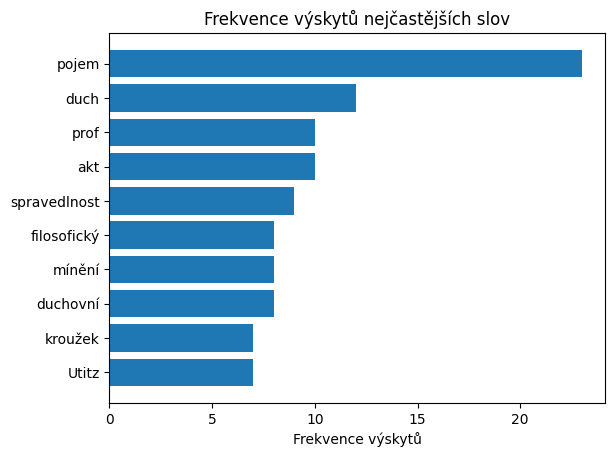

In [15]:
# kvůli horizontálnímu zobrazení prohodíme pořadí na našem listu
lemmata_mostfreq = lemmata_most_freq
lemmata_mostfreq.reverse()

# pro potřeby grafu přiřadíme hodnoty jednotlivým osám
height = [tup[1] for tup in lemmata_mostfreq]
bars = [tup[0] for tup in lemmata_mostfreq]
y_pos = np.arange(len(bars))

plt.barh(y_pos, height)
# graf si pojmenujeme a osu také
plt.yticks(y_pos, bars)
plt.xlabel('Frekvence výskytů')
plt.title('Frekvence výskytů nejčastějších slov')
# graf si zobrazíme
plt.show()

Přehled nejfrekventovanějších slov jistě představuje cennou informaci o obsahu zkoumaného textu či souboru textů. Neříká však nic o tom, jakým způsobem jsou zde příslušná slova použita. K tomu potřebujeme zaprvé a především informaci o tom, která slova se spolu a jak často spoluvyskytují. Tuto informaci získáme tak, že zkonstruujeme tzv. **kookurenční matici**. 



In [16]:
vocabulary = [tup[0] for tup in lemmata_freq.most_common(100)]
vect = CountVectorizer(vocabulary=vocabulary, lowercase=False)
X = vect.fit_transform([" ".join(sent) for sent in lemmatized_sentences])
Xc = (X.T * X)  # This is the matrix manipulation step
cooccurrence_matrix_df = pd.DataFrame(Xc.todense(), index=vocabulary, columns=vocabulary)
cooccurrence_matrix_df.head()

,pojem,duch,prof,akt,spravedlnost,filosofický,mínění,duchovní,kroužek,Utitz,...,nový,Kozákův,navazovat,deskriptivní,různý,důležitý,vztah,ideální,dra,pojetí
pojem,39,7,5,6,9,1,1,11,0,4,...,1,0,2,1,1,1,0,0,0,0
duch,7,12,5,2,2,1,0,2,1,2,...,0,1,0,0,1,0,1,1,1,1
prof,5,5,10,1,6,0,1,2,0,4,...,0,1,0,0,0,0,1,1,1,1
akt,6,2,1,12,2,0,0,5,0,1,...,1,0,0,1,0,0,1,0,2,1
spravedlnost,9,2,6,2,15,0,0,5,0,6,...,0,0,0,0,0,0,2,0,0,0


In [17]:
kontrola_pruchodu(ntb="nlp", arg1=vocabulary[:10])

Pokud jsme se dostali až jsem, hlavní část našeho úkolu byla splněna. Máme-li však čas a chuť, můžeme pokračovat dále.

> **Zde končí povinná část cvičení.**

## Rozšiřující analýza: Analýza všech děl z Archivu Jana Patočky 

In [18]:
def get_patocka(url):
  textdata = {}
  try:
    web_text = urlopen(url).read().decode("utf-8")
    soup = BeautifulSoup(web_text, "html.parser")
    text_title = soup.find("div", id="item_title").get_text()
    date = [div for div in soup.find_all("div", class_="col span_7_of_9")][3].get_text()
    text_dokumentu = soup.find("div", id="trans_full").get_text()
    text_dokumentu = " ".join(text_dokumentu.split())
    #print(id)
    textdata["url"] = url
    textdata["title"] = text_title
    textdata["date"] = date
    textdata["rawtext"] = text_dokumentu
  except:
    pass
  return textdata

Získejme zdrojový kód jedné stránky soupisu přepsaných textů a získejme URL odkazy všech dokumentů, na které odkazuje: 

In [19]:
base_url = "https://archiv.janpatocka.cz/items/browse?tags=fulltext&page="
page_url = base_url + str(2)
resp_text = requests.get(page_url).text
["https://archiv.janpatocka.cz" + href for href in re.findall("/items/show/\d+", resp_text)]

['https://archiv.janpatocka.cz/items/show/2657',
 'https://archiv.janpatocka.cz/items/show/2657',
 'https://archiv.janpatocka.cz/items/show/2656',
 'https://archiv.janpatocka.cz/items/show/2656',
 'https://archiv.janpatocka.cz/items/show/2655',
 'https://archiv.janpatocka.cz/items/show/2655',
 'https://archiv.janpatocka.cz/items/show/2654',
 'https://archiv.janpatocka.cz/items/show/2654',
 'https://archiv.janpatocka.cz/items/show/2653',
 'https://archiv.janpatocka.cz/items/show/2653',
 'https://archiv.janpatocka.cz/items/show/2652',
 'https://archiv.janpatocka.cz/items/show/2652',
 'https://archiv.janpatocka.cz/items/show/2651',
 'https://archiv.janpatocka.cz/items/show/2651',
 'https://archiv.janpatocka.cz/items/show/2650',
 'https://archiv.janpatocka.cz/items/show/2650',
 'https://archiv.janpatocka.cz/items/show/2649',
 'https://archiv.janpatocka.cz/items/show/2649',
 'https://archiv.janpatocka.cz/items/show/2648',
 'https://archiv.janpatocka.cz/items/show/2648',
 'https://archiv.jan

Tuto proceduru nyní zopakujeme pro všechny zbývající stránky:

In [25]:
docs_urls = []
base_url = "https://archiv.janpatocka.cz/items/browse?tags=fulltext&page="
for page_n in range(1,34):
  page_url = base_url + str(page_n)
  resp_text = requests.get(page_url).text
  page_urls = ["https://archiv.janpatocka.cz" + href for href in re.findall("/items/show/\d+", resp_text)]
  docs_urls.extend(page_urls)

kolik odkazů jsme získali?

In [33]:
len(docs_urls)

1158

In [47]:
docs_urls = list(set(docs_urls))
len(docs_urls)

579

In [48]:
docs_urls[:3]

['https://archiv.janpatocka.cz/items/show/2617',
 'https://archiv.janpatocka.cz/items/show/1546',
 'https://archiv.janpatocka.cz/items/show/98']

Nyní můžeme získat přepisy textů ze všech těchto stránek. Tato procedura však zabere značný čas. V rámci výuky ji tudíž můžeme přeskočit a načteme místo toho již předpřipravená data.

In [69]:
#data = []
#for url in docs_urls:
#  textdata = get_patocka(url)
#  data.append(textdata)
#patocka_all_df = pd.DataFrame(data)
#patocka_all_df = patocka_all_df.dropna()

Textová data ve sloupci `rawtext` si nyní můžeme lemmatizovat pomocí funkce níže. I tato procedura je však v případě celého korpusu relativně výpočetně náročná, a proto ji nyní také přeskočíme a načteme již lemmatizovaná data.

In [72]:
def get_lemmatized_sents(rawtext):
  try:
    doc = nlp(rawtext)
    lemmatized_sentences = []
    for sent in doc.sentences:
        sentence_lemmata = []
        for token in sent.words:
            if token.upos in ["PROPN", "NOUN", "VERB", "ADJ"]:
                sentence_lemmata.append(token.lemma)
        lemmatized_sentences.append(sentence_lemmata)
    return lemmatized_sentences
  except:
    return []

In [95]:
#patocka_all_df["lemmatized_sents"] = patocka_all_df["rawtext"].apply(get_lemmatized_sents)
# patocka_all_df.to_json("../data/patocka_all_df.json")

In [20]:
patocka_all_df = pd.read_json("../data/patocka_all_df.json")
patocka_all_df

/var/folders/57/tg7c_g894t5c2z3swkqzds5h0000gn/T/ipykernel_25544/1247116581.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  patocka_all_df = pd.read_json("../data/patocka_all_df.json")
/var/folders/57/tg7c_g894t5c2z3swkqzds5h0000gn/T/ipykernel_25544/1247116581.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  patocka_all_df = pd.read_json("../data/patocka_all_df.json")
/var/folders/57/tg7c_g894t5c2z3swkqzds5h0000gn/T/ipykernel_25544/1247116581.py:1: FutureWarning: The behavio

,url,title,date,rawtext,lemmatized_sents
0,https://archiv.janpatocka.cz/items/show/98,"Recenze na: J. Kratochvil, Meditace věků. Ději...",1932,Josef Kratochvil: Meditace věků. Dějinný vývoj...,"[[Josef, Kratochvil, meditace, věk], [dějinný,..."
1,https://archiv.janpatocka.cz/items/show/335,"Recenze na: H. Gouhier, La jeunesse d’Auguste ...",1936,None,[]
2,https://archiv.janpatocka.cz/items/show/66,"Recenze na: J. Benda, La fin de l’éternel",1929,"Julien Benda, La fin de 1’eternel, Paris, Gall...","[[Julien, Benda], [strana, cena, frs], [nový, ..."
3,https://archiv.janpatocka.cz/items/show/30,Gorgias\n,None,﻿Ještě ve stručnosti zopakuji hlavní body té K...,"[[stručnost, zopakovat, hlavní, bod, Kallikleů..."
4,https://archiv.janpatocka.cz/items/show/95,"Recenze na: G. Ipsen, Sprachphilosophie der Ge...",1932,"Philosophische Forschungsberichte, Junker und ...","[[Berlin], [Heft, Gunther, Ipsen, 8°, strana, ..."
...,...,...,...,...,...
358,https://archiv.janpatocka.cz/items/show/391,"Recenze na: L. Rieger, Idea filosofie",1938,None,[]
359,https://archiv.janpatocka.cz/items/show/364,"Recenze na: L. Robin, Platon",1937,None,[]
360,https://archiv.janpatocka.cz/items/show/282,"Recenze na: L. von Wiese, System der allgemein...",1933,Leopold von Wiese: System der allgemeinen Sozi...,"[[Leopold, Wiese], [u, Leipzig, Humblot, stran..."
361,https://archiv.janpatocka.cz/items/show/2661,Co je Evropa – šest zlomků,None,[Bytí: kosmos věcí...]1 Sein: Kosmos der Dinge...,"[[bytí, kosmos, věc, πργματα, φύσις], [πολις]..."


In [21]:
patocka_all_df.shape

(363, 5)

In [22]:
all_sents = [sent for doc in patocka_all_df["lemmatized_sents"] for sent in doc]
docs = [" ".join(sent) for sent in all_sents]
lemmata_flat = [t for s in all_sents for t in s]
lemmata_freqs = nltk.FreqDist(lemmata_flat).most_common()
vocabulary = [tup[0] for tup in lemmata_freqs][:500]
lemmata_freqs[:10]

[('mít', 3801),
 ('život', 2831),
 ('svět', 2785),
 ('moci', 2634),
 ('smysl', 2580),
 ('věc', 2569),
 ('člověk', 2182),
 ('způsob', 1713),
 ('bytí', 1614),
 ('muset', 1502)]

In [23]:
docs[:10]

['Josef Kratochvil meditace věk',
 'dějinný vývoj filosofický myšlení TV filosofie nový Kant dnešní doba Brno barvič Novotný',
 '',
 'strana',
 'Josef Kratochvil plodný katolický filosofický spisovatel ee obírat dějiny filosofie',
 'práce veřejnost přijímaný sympatie povzbudit dát podnik chybět síla souborný dějiny filosofie',
 'svazek referovat dějiny ukončený',
 'škoda ukázat malý vědecký cena práce veřejnost uváděný omyl autor najít vysoký míra autokritika',
 'dějiny filosofie Kratochvíl problém',
 'otázka metoda trápit podávat snůšek názor lada jednota podporovaný druhdy mínění moderní filosofie pestrý mosaika názor teorie vnitřní souvislost']

In [24]:
vect = CountVectorizer(vocabulary=vocabulary, lowercase=False)
X = vect.fit_transform(docs)
Xc = (X.T * X)  # This is the matrix manipulation step
cooccurrence_matrix_df = pd.DataFrame(Xc.todense(), index=vocabulary, columns=vocabulary)
cooccurrence_matrix_df.head()

,mít,život,svět,moci,smysl,věc,člověk,způsob,bytí,muset,...,ideál,začínat,rok,vnímání,jednoduchý,centrum,učinit,zjevovat,dojem,přel
mít,5015,424,422,539,762,512,444,240,272,439,...,19,22,5,15,17,15,16,26,43,4
život,424,4589,413,298,425,233,551,333,169,174,...,21,12,1,9,18,20,9,5,12,8
svět,422,413,4361,316,366,335,410,211,284,160,...,5,10,7,9,10,12,15,40,12,6
moci,539,298,316,3392,480,348,314,251,254,287,...,14,7,7,8,17,6,10,21,21,5
smysl,762,425,366,480,3614,294,293,190,294,196,...,13,9,5,6,15,12,14,35,8,10


In [25]:
svd = TruncatedSVD(n_components=100)  # choose the number of components
X_reduced = svd.fit_transform(Xc)

In [26]:
kv = KeyedVectors(vector_size=X_reduced.shape[1])
for word, vector in zip(vocabulary, X_reduced):
  kv.add_vector(word, vector)

/Users/vojtechkase/Projects/pribehy-dat/pribehy_venv/lib/python3.10/site-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [30]:
kv.most_similar("svět")

/Users/vojtechkase/Projects/pribehy-dat/pribehy_venv/lib/python3.10/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


[('přirozený', 0.8993819952011108),
 ('naivní', 0.7744329571723938),
 ('technický', 0.7456496357917786),
 ('božský', 0.7109482884407043),
 ('okolí', 0.6663277745246887),
 ('horizont', 0.6653637290000916),
 ('křesťanství', 0.6603729724884033),
 ('pochopitelný', 0.6338645815849304),
 ('radikální', 0.6329202651977539),
 ('universální', 0.6300941109657288)]